### Задание

Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров (да, обычно в таких компаниях есть приложение для курьеров и отдельно приложение для потребителей).

У вас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема — к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности. 

Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой. 

Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.

### Описание данных

* order_id - идентификатор заказа
* delivery_time - время доставки в минутах
* district - район доставки
* experiment_group - принадлежность экспериментальной группе

### Гипотезы
Нулевая гипотеза (H0): Разницы между средним временем доставки в тестовой и контрольной группе нет.<br>
Альтернативная гипотеза (H1): Разница между средним временем доставки в тестовой и контрольной группе есть.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pingouin as pg
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
data = pd.read_csv(r'data\data_pizza_delivery.csv')

In [3]:
data.head()

,order_id,delivery_time,district,experiment_group
0,3159,44.0,Purlieus,control
1,10426,51.0,Purlieus,control
2,9155,46.0,Purlieus,control
3,10699,34.0,Purlieus,control
4,10061,43.0,Purlieus,control


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20196 entries, 0 to 20195
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_id          20196 non-null  int64  
 1   delivery_time     20196 non-null  float64
 2   district          20196 non-null  object 
 3   experiment_group  20196 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 631.2+ KB


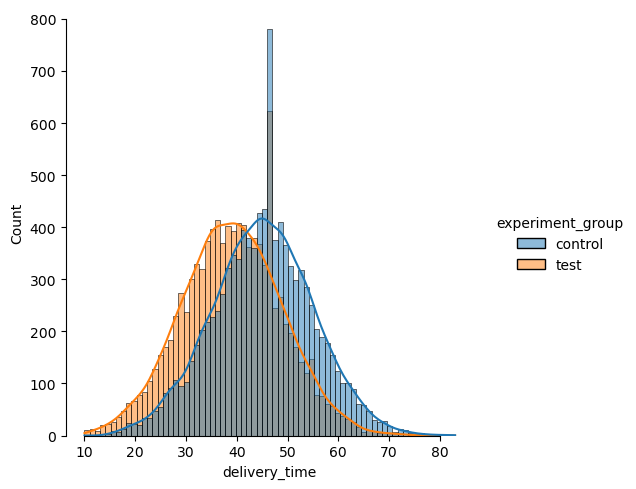

In [5]:
sns.displot(data=data, x='delivery_time', hue='experiment_group', kde=True)
sns.despine(offset=0, trim=True)

Если обратить внимание на распределение, то визуально можно обнаружить, что данные из тестовой группы смещены левее по оси `X`, чем данные из контрольной группы.<br>
При этом визуально наблюдается, что обе выборки распределены нормально. Чтобы это наглядно продемонстрировать, можно дополнительно построить график `qqplot`

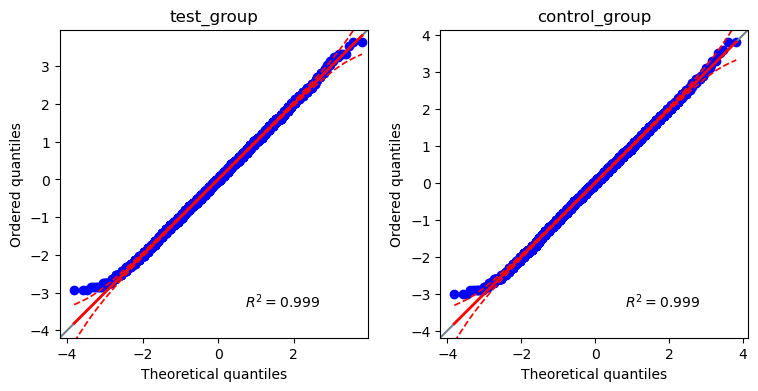

In [6]:
x_test = data.loc[data['experiment_group']=='test', 'delivery_time']
x_control = data.loc[data['experiment_group']=='control', 'delivery_time']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
ax1 = pg.qqplot(x_test, dist='norm', ax=ax1)
ax1.set_title('test_group')
ax2 = pg.qqplot(x_control, dist='norm', ax=ax2)
ax2.set_title('control_group')
plt.show()

In [7]:
pg.normality(data=data, dv='delivery_time', group='experiment_group', method='shapiro')

,W,pval,normal
experiment_group,,,
control,0.998722,3.223325e-07,False
test,0.998628,1.172024e-07,False


Тест Шапиро-Уилка показывает, что данные распределены `ненормально`. Это может быть вызвано большим количеством наблюдений в выборке.

In [8]:
data['experiment_group'].value_counts()

test       10104
control    10092
Name: experiment_group, dtype: int64

In [9]:
pg.normality(data=data, dv='delivery_time', group='experiment_group', method='normaltest')

,W,pval,normal
experiment_group,,,
control,0.253498,0.880955,True
test,7.024157,0.029835,False


Можно обратить внимание, что данные в _контрольной группе_ распределены `нормально`, а данные в _тестовой группе_ распределены `ненормально`.<br>
При этом визуально мы видим, что наша выборка имеет нормальное распределение. И учитывая большой набор данных используем допущение, что наши данные распределены `нормально`.

In [10]:
data.groupby('experiment_group').agg({'delivery_time': np.std}).round(3)

,delivery_time
experiment_group,
control,9.990
test,9.883


Для проверки гипотезы о существенности изменения времени доставки в тестовой и контрольной группах проведем `t-test`.

In [11]:
data_test_gr = data.loc[data['experiment_group']=='test', 'delivery_time']
data_control_gr = data.loc[data['experiment_group']=='control', 'delivery_time']

In [12]:
pg.ttest(data_test_gr, data_control_gr)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-43.035552,20191.127788,two-sided,0.0,"[-6.29, -5.74]",0.605658,inf,1.0


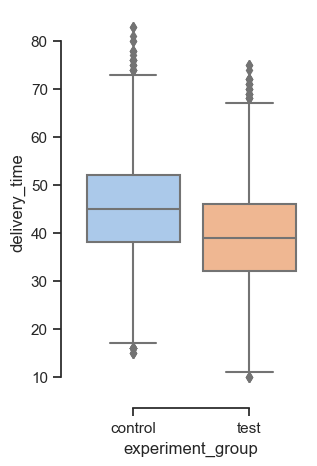

In [13]:
plt.figure(figsize=(3, 5))
sns.set_theme(style='ticks', palette='pastel')
sns.boxplot(x='experiment_group', y='delivery_time', data=data)
sns.despine(offset=10, trim=True)

Можем обратить внимание, что `p-value` в нашем случае получилось меньше 0.05, что дает нам достаточно оснований отклонить нулевую гипотезу (о равенстве среднего времени доставки в тестовой и контрольной группе) в пользу альтернативной.

Для интерпретации результатов, посмотрим на сколько сократилось среднее время доставки пиццы:

In [14]:
print('На', abs(round(data_test_gr.mean() - data_control_gr.mean(), 2)),
      'мин. уменьшилось среднее время доставки пиццы.')
print('Что составляет', abs(round((data_test_gr.mean() - data_control_gr.mean()) \
                                / data_control_gr.mean() * 100, 2)),
      '%.\nИ является статистически значимым результатом.')

На 6.02 мин. уменьшилось среднее время доставки пиццы.
Что составляет 13.35 %.
И является статистически значимым результатом.
